/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:26: UserWarning: WARN: Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+
  "Gym minimally supports python 3.6 as the python foundation not longer supports the version, please update your version to 3.7+"
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/root/anaconda3/envs/cpu/lib/python3.6/site-packages/gym/core.py:330: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_

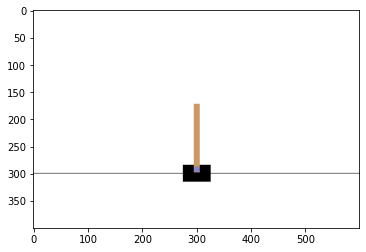

In [1]:
import gym
from matplotlib import pyplot as plt
%matplotlib inline

#创建环境
env = gym.make('CartPole-v0')
env.reset()


#打印游戏
def show():
    plt.imshow(env.render(mode='rgb_array'))
    plt.show()


show()

In [2]:
import torch

#定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2),
    torch.nn.Softmax(dim=1),
)

model_td = sequential = torch.nn.Sequential(
    torch.nn.Linear(4, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 1),
)

model(torch.randn(2, 4)), model_td(torch.randn(2, 4))

(tensor([[0.4340, 0.5660],
         [0.3047, 0.6953]], grad_fn=<SoftmaxBackward0>),
 tensor([[0.3946],
         [0.3271]], grad_fn=<AddmmBackward0>))

In [3]:
import random


#得到一个动作
def get_action(state):
    state = torch.FloatTensor(state).reshape(1, 4)
    #[1, 4] -> [1, 2]
    prob = model(state)

    #根据概率选择一个动作
    action = random.choices(range(2), weights=prob[0].tolist(), k=1)[0]

    return action


get_action([1, 2, 3, 4])

1

In [4]:
def get_data():
    states = []
    rewards = []
    actions = []
    next_states = []
    overs = []

    #初始化游戏
    state = env.reset()

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        next_state, reward, over, _ = env.step(action)

        #记录数据样本
        states.append(state)
        rewards.append(reward)
        actions.append(action)
        next_states.append(next_state)
        overs.append(over)

        #更新游戏状态,开始下一个动作
        state = next_state

    #[b, 4]
    states = torch.FloatTensor(states).reshape(-1, 4)
    #[b, 1]
    rewards = torch.FloatTensor(rewards).reshape(-1, 1)
    #[b, 1]
    actions = torch.LongTensor(actions).reshape(-1, 1)
    #[b, 4]
    next_states = torch.FloatTensor(next_states).reshape(-1, 4)
    #[b, 1]
    overs = torch.LongTensor(overs).reshape(-1, 1)

    return states, rewards, actions, next_states, overs


get_data()

/root/anaconda3/envs/cpu/lib/python3.6/site-packages/ipykernel_launcher.py:31: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811701593/work/torch/csrc/utils/tensor_new.cpp:201.)


(tensor([[-0.0451,  0.0146,  0.0370,  0.0127],
         [-0.0448,  0.2092,  0.0372, -0.2681],
         [-0.0406,  0.0135,  0.0319,  0.0361],
         [-0.0403, -0.1820,  0.0326,  0.3387],
         [-0.0440, -0.3776,  0.0394,  0.6414],
         [-0.0515, -0.1830,  0.0522,  0.3614],
         [-0.0552, -0.3789,  0.0594,  0.6701],
         [-0.0627, -0.5748,  0.0728,  0.9809],
         [-0.0742, -0.7708,  0.0925,  1.2955],
         [-0.0897, -0.9669,  0.1184,  1.6157],
         [-0.1090, -0.7734,  0.1507,  1.3621],
         [-0.1245, -0.9701,  0.1779,  1.6979]]),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]),
 tensor([[1],
         [0],
         [0],
         [0],
         [1],
         [0],
         [0],
         [0],
         [0],
         [1],
         [0],
         [1]]),
 tensor([[-0.0448,  0.2092,  0.0372, -0.2681],
         [-0.0406,  0.0135,  0.0319

In [5]:
from IPython import display


def test(play):
    #初始化游戏
    state = env.reset()

    #记录反馈值的和,这个值越大越好
    reward_sum = 0

    #玩到游戏结束为止
    over = False
    while not over:
        #根据当前状态得到一个动作
        action = get_action(state)

        #执行动作,得到反馈
        state, reward, over, _ = env.step(action)
        reward_sum += reward

        #打印动画
        if play and random.random() < 0.2:  #跳帧
            display.clear_output(wait=True)
            show()

    return reward_sum


test(play=False)

15.0

In [6]:
def train():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    optimizer_td = torch.optim.Adam(model_td.parameters(), lr=1e-2)
    loss_fn = torch.nn.MSELoss()

    #玩N局游戏,每局游戏训练一次
    for i in range(1000):
        #玩一局游戏,得到数据
        #states -> [b, 4]
        #rewards -> [b, 1]
        #actions -> [b, 1]
        #next_states -> [b, 4]
        #overs -> [b, 1]
        states, rewards, actions, next_states, overs = get_data()

        #计算values和targets
        #[b, 4] -> [b ,1]
        values = model_td(states)

        #[b, 4] -> [b ,1]
        targets = model_td(next_states) * 0.98
        #[b ,1] * [b ,1] -> [b ,1]
        targets *= (1 - overs)
        #[b ,1] + [b ,1] -> [b ,1]
        targets += rewards

        #时序差分误差
        #[b ,1] - [b ,1] -> [b ,1]
        delta = (targets - values).detach()

        #重新计算对应动作的概率
        #[b, 4] -> [b ,2]
        probs = model(states)
        #[b ,2] -> [b ,1]
        probs = probs.gather(dim=1, index=actions)

        #根据策略梯度算法的导函数实现
        #只是把公式中的reward_sum替换为了时序差分的误差
        #[b ,1] * [b ,1] -> [b ,1] -> scala
        loss = (-probs.log() * delta).mean()

        #时序差分的loss就是简单的value和target求mse loss即可
        loss_td = loss_fn(values, targets.detach())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        optimizer_td.zero_grad()
        loss_td.backward()
        optimizer_td.step()

        if i % 100 == 0:
            test_result = sum([test(play=False) for _ in range(10)]) / 10
            print(i, test_result)


train()

0 21.4
100 20.6
200 42.3
300 64.1
400 147.3
500 158.9
600 195.3
700 190.2
800 200.0
900 200.0


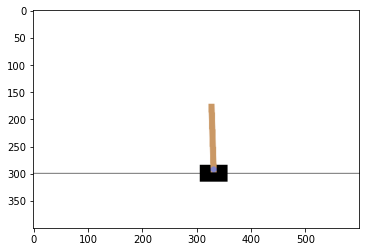

200.0

In [7]:
test(play=True)